In [1]:
import matplotlib    #アニメーション用
matplotlib.use('nbagg')    #Jupyter Notebook上でのアニメーション実行用
import matplotlib.animation as anm    #アニメーション用
import matplotlib.pyplot as plt    #描画用
import matplotlib.patches as pathces    #図形描画用  
import math    #数学関数・変数使用用
import numpy as np    #演算用

In [2]:
#シミュレーション世界のクラス
class World:
    def __init__(self, time_span, time_interval, debug=False, goal_pos=[None, None], map_size=[100.0, 100.0]):
        self.objects = []    #オブジェクトを格納
        self.time_span = time_span    #シミュレーション時間
        self.time_interval = time_interval    #ステップ時間
        self.debug = debug    #デバッグモード
        self.goal_pos = np.array([goal_pos[0], goal_pos[1]]).T    #ゴールの座標
        self.xlim = map_size[0]    #マップサイズX軸
        self.ylim = map_size[1]    #マップサイズY軸
        
    def append(self, obj):
        self.objects.append(obj)    #オブジェクトをWorldクラスに追加
        
    def draw(self):    #地図にオブジェクトを描画する関数
        fig = plt.figure(figsize=(4, 4))    #図形定義
        ax = fig.add_subplot(111)    #図形の中にグラフを追加
        ax.set_aspect('equal')    #比率を1:1に
        ax.set_xlim(-self.xlim, self.xlim)    #X軸の範囲
        ax.set_ylim(-self.ylim, self.ylim)    #Y軸の範囲
        ax.set_xlabel("X", fontsize=10)    #X軸ラベル
        ax.set_ylabel("Y", fontsize=10)    #Y軸ラベル
        
        elems = []    #描画する要素を格納
        
        if self.debug:    #デバッグモードか検証モードか
            #デバッグモード
            for i in range(1000): self.one_step(i, elems, ax)    #描画はせずにとにかく実行
        else:
            #検証モード
            self.ani = anm.FuncAnimation(
                fig,    #図に関する命令
                self.one_step,    #図を作成するメソッド
                fargs=(elems, ax),    #one_stepメソッドに渡す関数，変数iは1から順に勝手に増えていく
                frames=int(self.time_span/self.time_interval)+1,    #フレーム数
                interval=int(self.time_interval*1000),    #シミュレーション継続時間
                repeat=False    #繰り返し無効
            )    #アニメーションの実行
            plt.show()    #描画

    def one_step(self, i, elems, ax):    #1ステップごとに呼び出される関数
        while elems: elems.pop().remove()    #描画されている図形を取り除く
        if not (self.goal_pos[0] == None or self.goal_pos[1] == None):    #ゴールがある場合，描画する
            c = ax.scatter(
                self.goal_pos[0]+0.034*self.xlim,
                self.goal_pos[1]+0.1*self.ylim,
                s=50,
                marker=">",
                label="landmarks",
                color="red"
            )    #旗の赤い部分を追加
            elems += ax.plot(
                [self.goal_pos[0], self.goal_pos[0]],
                [self.goal_pos[1], self.goal_pos[1]+0.13*self.ylim],
                color="black"
            )    #旗の棒を追加
        
        time_str = "t=%.2f[s]" % (self.time_interval*i)    #時間を表示用に文字列へ変換
        elems.append(
            ax.text(
                -self.xlim*0.95,    #時刻を表示するX座標
                self.ylim*0.9,    #時刻を表示するY座標
                time_str,    #表示する内容
                fontsize=10    #フォントサイズ
            )
        )    #時刻の表示
        for obj in self.objects:     #オブジェクトを順番に描画
            obj.draw(ax, elems)    #描画（オブジェクトのクラスのメソッドdrawを呼び出し）
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    #オブジェクトにone_stepメソッドがあるか確認

In [3]:
#理想的なロボットを構成するクラス
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        self.pose = pose    #位置
        self.r = 0.2    #ローバーの半径（描画上のサイズ）
        self.color = color    #ローバーの色（描画上の色）
        self.agent = agent    #ローバーが従うエージョン
        self.poses = [pose]    #ローバーの軌跡
        self.sensor = sensor    #ローバーに搭載されているセンサ
        
    def state_transition(self, nu, omega, time, pose):    #ローバーの移動速度に基づいて1ステップ後の位置を求める関数
        t0 = pose[2]    #1時刻前のローバーの向き(角度）
        if math.fabs(omega) < 1e-10:
            #回転速度が十分小さい場合
            returnPose = pose + np.array([
                nu*math.cos(t0),    #X軸
                nu*math.sin(t0),    #Y軸
                omega    #角度
            ]) * time
        else:
            #回転速度が小さくない場合
            returnPose = pose + np.array([
                nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),    #X軸
                nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),    #Y軸
                omega*time    #角度
            ])  
        
        #角度が定義域外である場合は定義域内に収まるように変換する
        while returnPose[2] > math.pi:
            returnPose[2] -= 2*math.pi
        while returnPose[2] < -math.pi:
            returnPose[2] += 2*math.pi
        return returnPose
        
    def draw(self, ax, elems):    #ローバーと経路の描画する関数
        x, y, theta = self.pose    #ローバーの位置，姿勢
        xn = x + self.r * math.cos(theta)    #ローバー先端のX座標
        yn = y + self.r * math.sin(theta)    #ローバー先端のY座標
        elems += ax.plot([x, xn], [y, yn], color=self.color)    #ローバーの表示
        c = pathces.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)    #ローバー本体の描画
        elems.append(ax.add_patch(c))    #ローバーを図に追加
        
        self.poses.append(self.pose)    #軌跡の追加
        elems += ax.plot(
            [e[0] for e in self.poses],    #軌跡のX座標
            [e[1] for e in self.poses],    #軌跡のY座標
            linewidth=0.5,    #軌跡のライン幅
            color="black"    #軌跡の色
        )    #経路の追加
        if self.sensor and len(self.pose)  > 1:
            self.sensor.draw(ax, elems)    #センサ値を描画
        
    def one_step(self, time_interval):    #ステップ
        if not self.agent: return    #Agentクラスを与えられていなければ何もしない      
        obj = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.action(obj)    #移動速度を更新
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)    #位置を更新

In [4]:
#ロボットが持つ理想的なセンサを構成するクラス
class IdealSensor:
    def __init__(self):
        self.real_pose = [0, 0, 0]    #ローバーの真の位置，姿勢
        self.pose = [0, 0, 0]    #センサから得られたローバの位置，姿勢
    
    def data(self, obj_pose):
        self.real_pose = obj_pose    #ローバーの真の位置
        self.pose = np.hstack([
            self.getGPS(obj_pose),
            self.getDirection(obj_pose)
        ])    #位置と姿勢を取り出し結合
        return self.pose    #センサ値を返す
    
    def getGPS(self, pose):    #GPSから得られた座標を返す関数
        return np.array([pose[0], pose[1]]).T    #位置を返す
    
    def getDirection(self, pose):    #地磁気センサから得られたローバの向きを返す関数
        return np.array([pose[2]]).T    #向きを返す
    
    def draw(self, ax, elems):
        elems.append(
            ax.text(
                self.real_pose[0]-2,    #センサ値を描画するX軸の値
                self.real_pose[1]-2,    #センサ値を描画するY軸の値
                "{:.1f},{:.1f},{:.1f}\n".format(float(self.pose[0]), float(self.pose[1]), float(self.pose[2]*180/math.pi)),    #描画するセンサ値,
                fontsize=8    #描画する際のフォントサイズ
            )
        )    #ローバーの位置座標，姿勢を表示

In [5]:
#ロボットの行動を決定するエージェントクラス
class Agent:
    def __init__(self, goal_pos=[0, 0], motor=[0, 0]):
        self.nu = 0    #直進速度の初期化
        self.omega = 0    #回転速度の初期化
        self.goal_pos = goal_pos    #ゴール位置（エージェントはゴールの座標を知っている前提）
        self.motorL, self.motorR = motor[0], motor[1]
        
    def action(self, pose):    #ローバーの移動速度を返す関数
        #このメソッドの中身はクラスを継承しオーバーライドすることで他の行動に変更することができる
        #メイン関数のクラスAgent2を参考
        self.motor(self.motorL, self.motorR)    #制御指令値を設定
        return self.nu, self.omega
    
    def motor(self, motorL=0, motorR=0):    #制御指令値からローバーの移動速度へ変換する関数
        #モータパワーの絶対値をを100以下にする
        motorL = 100 if motorL > 100 else motorL
        motorL = -100 if motorL < -100 else motorL
        motorR = 100 if motorR > 100 else motorR
        motorR = -100 if motorR < -100 else motorR
        
        motorL /= 1    #スケール変換
        motorR /= 1    #スケール変換
        self.nu = motorL + motorR     #直進速度を求める
        self.omega = motorR - motorL    #回転速度を求める

<IPython.core.display.Javascript object>


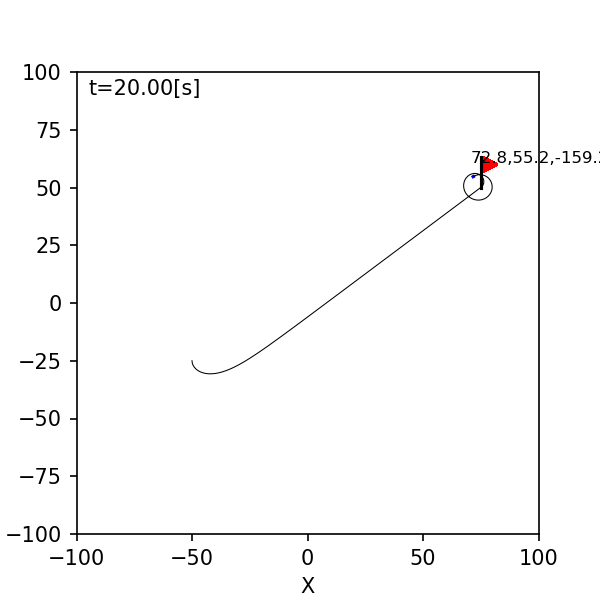

In [6]:
if __name__ == "__main__":    #ライブラリとして読み込む場合は実行しない
    class Agent2(Agent):    #Agentクラスから継承し，新たなエージェントを定義
        def __init__(self, goal_pos=[0, 0]):
            super().__init__()    #親クラスから継承
            self.goal_pos = goal_pos    #ゴール座標

        def action(self, pose):    #actionメソッドをオーバーライド
            kp = 0.01    #比例ゲイン
            direction = math.atan2(self.goal_pos[1] - pose[1], self.goal_pos[0] - pose[0])*180/math.pi    #ゴールの方角
            rover_dir = pose[2]*180/math.pi    #ローバーの向いている方角
            deltaTheta = ((540 + direction - rover_dir) % 360) - 180    #ローバーの向いている方角とゴールの向いている方角の差
            mPF = 5    #モータ前進成分
            mPS = kp * deltaTheta    #モータ回転成分
            mPL = mPF - mPS    #左モータパワー
            mPR = mPF + mPS    #右モータパワー
            
            #モータパワーの絶対値をを100以下にする
            #エージェントクラスにも同じ処理が実装されているが，それは制約を実装したもの
            #下のコードは誤った入力による事故を防止するための実装
            mPL = 100 if mPL > 100 else mPL
            mPR = 100 if mPR > 100 else mPR
            mPL = -100 if mPL < -100 else mPL
            mPR = -100 if mPR < -100 else mPR
            
            self.motor(mPL, mPR)    #モータの駆動（ローバーの移動速度が自動的に計算される）
            #with open("data.txt", "a") as f:    #計算値をファイルに保存（デバッグ用）
            #    f.write("{} {} {} {} {} {}\n".format(direction, rover_dir, deltaTheta, mPS, mPL, mPR))
            return self.nu, self.omega    #ローバーの移動速度を返す
            
    time_finish = 20    #シミュレーション終了時間
    time_interval = 0.1    #ステップ時間
    goal = [75, 50]    #ゴールの座標
    
    world = World(
        time_finish,    #シミュレーション終了時間
        time_interval,    #ステップ時間
        debug=False,    #デバッグモードか検証モードか
        map_size=[100,100],    #地図サイズ
        goal_pos=goal    #ゴール座標
    )    #地図の実装

    agent1 = Agent(motor=[0, 0])
    agent2 = Agent2(goal)    #エージェントの実装

    robot = IdealRobot(
        np.array([-50, -25, -math.pi/2]).T,    ##初期位置，姿勢
        agent=agent2,    #ローバーが従うエージェント
        sensor=IdealSensor(),   #ローバーに搭載されているセンサ
        color="blue"    #ローバの色（描画上の設定）
    )    #ロボットの実装
    
    world.append(robot)    #世界地図にローバーを組み込む
    world.draw()    #世界地図の描画